<a href="https://colab.research.google.com/github/metropooping/LSTM-EV-Load-Forecasting/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA LOADING**

In [1]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install --upgrade pip
!pip install kaggle

# Make directory and copy token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [3]:
!kaggle datasets download -d anshtanwar/residential-ev-chargingfrom-apartment-buildings

Dataset URL: https://www.kaggle.com/datasets/anshtanwar/residential-ev-chargingfrom-apartment-buildings
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/1.10M [00:00<?, ?B/s]
100% 1.10M/1.10M [00:00<00:00, 119MB/s]


In [4]:
!unzip "residential-ev-chargingfrom-apartment-buildings.zip"

Archive:  residential-ev-chargingfrom-apartment-buildings.zip
  inflating: archive (34)/Dataset 1_EV charging reports.csv  
  inflating: archive (34)/Dataset 2_Hourly EV loads - Per user.csv  
  inflating: archive (34)/Dataset 3a_Hourly EV loads - Aggregated private.csv  
  inflating: archive (34)/Dataset 3b_Hourly EV loads - Aggregated shared.csv  
  inflating: archive (34)/Dataset 5_AMS data from garage Bl2.csv  
  inflating: archive (34)/Dataset 6_Local traffic distribution.csv  
  inflating: archive (34)/Norway_Trondheim_ExactLoc_Weather.csv  


In [5]:
%cd "archive (34)"

/content/archive (34)


In [6]:
!ls

'Dataset 1_EV charging reports.csv'
'Dataset 2_Hourly EV loads - Per user.csv'
'Dataset 3a_Hourly EV loads - Aggregated private.csv'
'Dataset 3b_Hourly EV loads - Aggregated shared.csv'
'Dataset 5_AMS data from garage Bl2.csv'
'Dataset 6_Local traffic distribution.csv'
 Norway_Trondheim_ExactLoc_Weather.csv


# Preprocessing

## EV LOAD WEEKLY

In [7]:
# Reload the raw dataset with correct delimiter
import pandas as pd

df1 = pd.read_csv("Dataset 1_EV charging reports.csv", delimiter=';')

# Confirm reset
df1.head()


,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05",Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","0,136666667",Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,"29,87","8,216388889",Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,23.12.2018 16:40,16.0,"15,56","24,41972222",Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,24.12.2018 23:02,23.0,"3,62","0,970555556",Dec,Monday,late evening (21-midnight),Less than 3 hours


In [8]:
# Reload the dataset properly
df1 = pd.read_csv("Dataset 1_EV charging reports.csv", delimiter=';')

# Replace commas with periods in El_kWh column
df1['El_kWh'] = df1['El_kWh'].str.replace(',', '.').astype(float)

# Convert Start_plugin to datetime
df1['Start_plugin'] = pd.to_datetime(df1['Start_plugin'], dayfirst=True)

# Filter for 2019 data
df_filtered = df1[(df1['Start_plugin'] >= '2019-01-01') & (df1['Start_plugin'] < '2020-01-01')].copy()

# Create 'week' column
df_filtered['week'] = df_filtered['Start_plugin'].dt.to_period('W')

# Group and sum by week
weekly_load = df_filtered.groupby('week')['El_kWh'].sum().reset_index()
weekly_load.rename(columns={'El_kWh': 'ev_load_kWh'}, inplace=True)
weekly_load['week'] = weekly_load['week'].astype(str)

# Display result
weekly_load

,week,ev_load_kWh
0,2018-12-31/2019-01-06,103.24
1,2019-01-07/2019-01-13,224.91
2,2019-01-14/2019-01-20,328.54
3,2019-01-21/2019-01-27,361.84
4,2019-01-28/2019-02-03,347.01
5,2019-02-04/2019-02-10,192.84
6,2019-02-11/2019-02-17,434.59
7,2019-02-18/2019-02-24,438.24
8,2019-02-25/2019-03-03,698.59
9,2019-03-04/2019-03-10,604.56


# Modelling/Forecasting

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.2487
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2228 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1626
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1048 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0536
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0372 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0661 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0389 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0218
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0292
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0427
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0431
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0409
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0374
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0319
Epoch 16/200
2

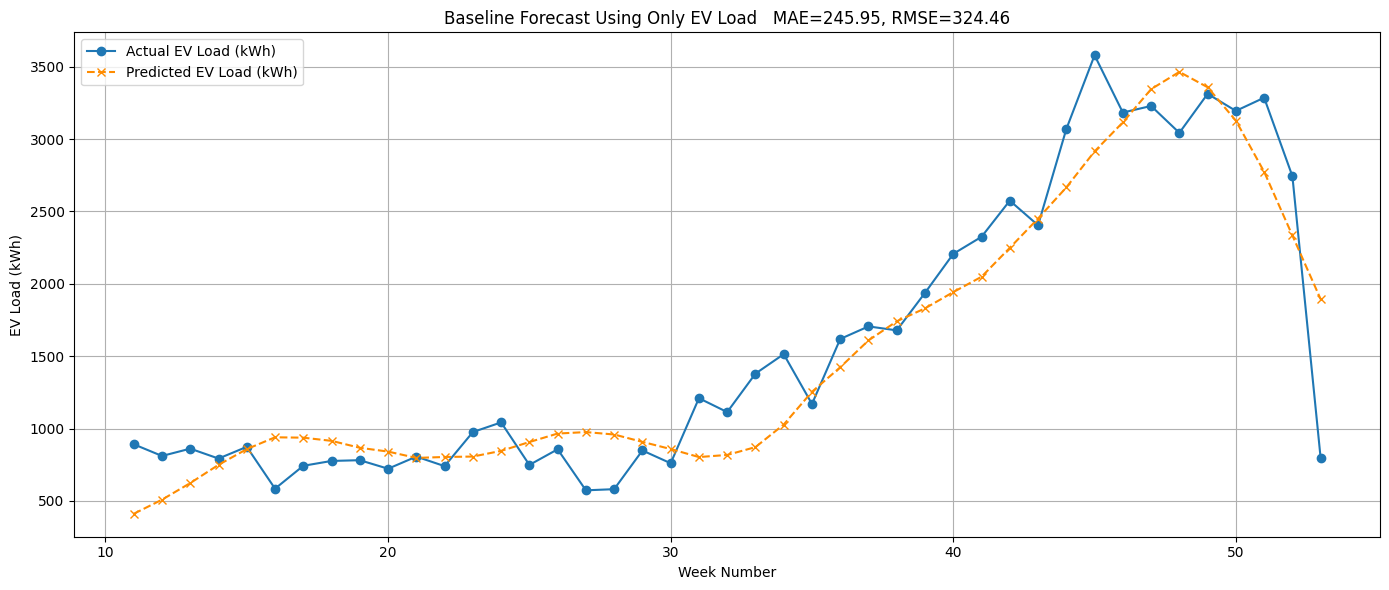

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Step 1: Load Target Only ===
ev_data = weekly_load['ev_load_kWh'].values.reshape(-1, 1)

# === Step 2: Normalize ===
scaler_y = MinMaxScaler()
ev_scaled = scaler_y.fit_transform(ev_data)

# === Step 3: Create Sequences with same lookback ===
lookback = 10
X_seq, y_seq = [], []
for i in range(lookback, len(ev_scaled)):
    X_seq.append(ev_scaled[i - lookback:i])
    y_seq.append(ev_scaled[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# === Step 4: Use all data for training ===
X_train, y_train = X_seq, y_seq

# === Step 5: Build Model (same structure) ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.add(Dense(1))
model.add(Activation('relu'))

# === Step 6: Train with same epochs ===
history = model.fit(X_train, y_train, epochs=200, verbose=1)

# === Step 7: Predict and Inverse Transform ===
y_pred_scaled = model.predict(X_train)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f"MAE: {mae:.2f} kWh")
print(f"RMSE: {rmse:.2f} kWh")

# === Step 8: Plot with Week Numbers ===
week_numbers = np.arange(lookback + 1, lookback + 1 + len(y_pred))

plt.figure(figsize=(14, 6))
plt.plot(week_numbers, y_actual, label='Actual EV Load (kWh)', marker='o', linestyle='-', color='tab:blue')
plt.plot(week_numbers, y_pred, label='Predicted EV Load (kWh)', marker='x', linestyle='--', color='darkorange')

plt.title(f"Baseline Forecast Using Only EV Load   MAE={mae:.2f}, RMSE={rmse:.2f}")
plt.xlabel("Week Number")
plt.ylabel("EV Load (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0878
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0726
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0549
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0362
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0212
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0118
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0118
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0162
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0174
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0205
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0149
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0088
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0095
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0061
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0131
Epoch 16/200
1/1 ━━━━━━━━━

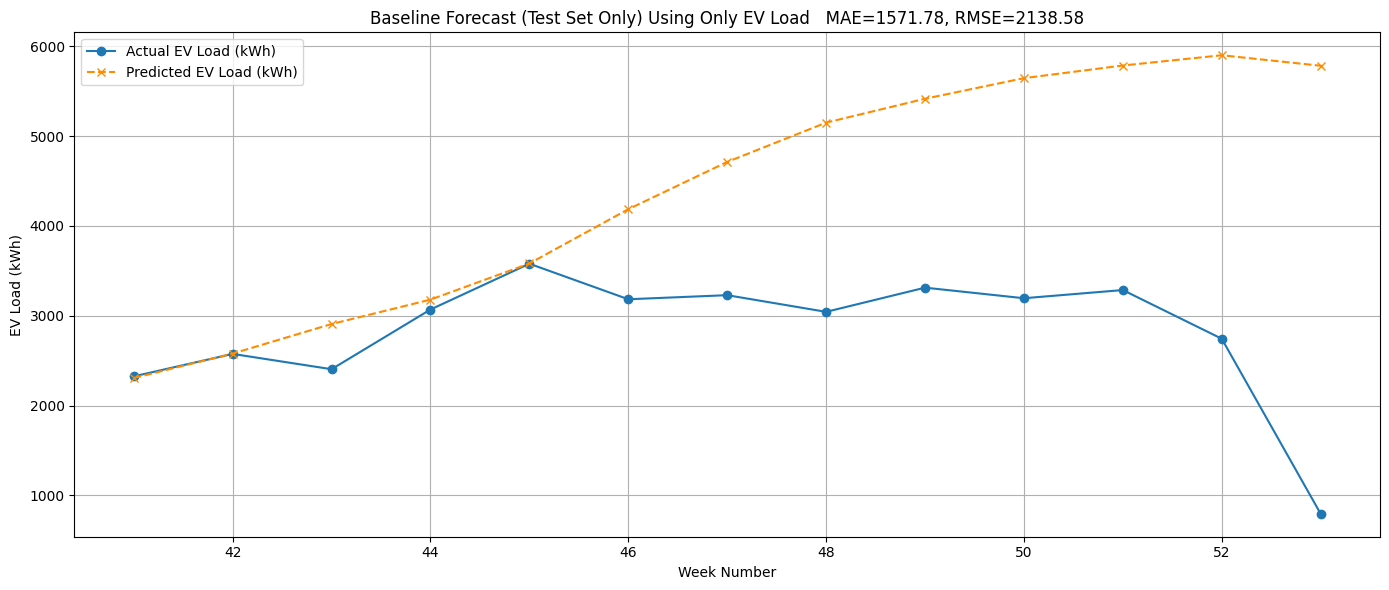

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Step 1: Load EV Load Only ===
ev_data = weekly_load['ev_load_kWh'].values.reshape(-1, 1)
total_weeks = len(ev_data)

# === Step 2: Normalize ===
scaler_y = MinMaxScaler()
ev_scaled = scaler_y.fit_transform(ev_data)

# === Step 3: Create Sequences ===
lookback = 10
X_seq, y_seq = [], []
for i in range(lookback, len(ev_scaled)):
    X_seq.append(ev_scaled[i - lookback:i])
    y_seq.append(ev_scaled[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# === Step 4: 70/30 Train-Test Split ===
split_index = int(len(X_seq) * 0.7)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

# === Step 5: Build Model ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.add(Dense(1))
model.add(Activation('relu'))

# === Step 6: Train Model ===
history = model.fit(X_train, y_train, epochs=200, verbose=1)

# === Step 7: Predict on Test ===
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# === Step 8: Evaluate ===
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f"MAE: {mae:.2f} kWh")
print(f"RMSE: {rmse:.2f} kWh")

# === Step 9: Plot with Week Numbers ===
# We skip the first 'lookback' weeks and then adjust based on the test split
week_numbers = np.arange(lookback + split_index + 1, total_weeks + 1)

plt.figure(figsize=(14, 6))
plt.plot(week_numbers, y_test_actual, label='Actual EV Load (kWh)', marker='o', linestyle='-', color='tab:blue')
plt.plot(week_numbers, y_pred, label='Predicted EV Load (kWh)', marker='x', linestyle='--', color='darkorange')
plt.title(f"Baseline Forecast (Test Set Only) Using Only EV Load   MAE={mae:.2f}, RMSE={rmse:.2f}")
plt.xlabel("Week Number")
plt.ylabel("EV Load (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
